In [6]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffusion_utilities import *
from contextUnet import ContextUnet

In [7]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# re setup optimizer
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [9]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

### Train

In [10]:
dataset = CustomDataset("./data/sprites_1788_16x16.npy", "./data/sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# training with context code
# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2 )
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)
        
        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps, c=c)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
        print('saved model at ' + save_dir + f"context_model_{ep}.pth")

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)
epoch 0


100%|██████████| 894/894 [00:58<00:00, 15.16it/s]


saved model at ./weights/context_model_0.pth
epoch 1


100%|██████████| 894/894 [00:56<00:00, 15.80it/s]


epoch 2


100%|██████████| 894/894 [00:56<00:00, 15.90it/s]


epoch 3


100%|██████████| 894/894 [00:56<00:00, 15.73it/s]


epoch 4


100%|██████████| 894/894 [01:05<00:00, 13.74it/s]


saved model at ./weights/context_model_4.pth
epoch 5


100%|██████████| 894/894 [01:05<00:00, 13.75it/s]


epoch 6


100%|██████████| 894/894 [01:04<00:00, 13.88it/s]


epoch 7


100%|██████████| 894/894 [01:04<00:00, 13.84it/s]


epoch 8


100%|██████████| 894/894 [01:04<00:00, 13.97it/s]


saved model at ./weights/context_model_8.pth
epoch 9


100%|██████████| 894/894 [01:03<00:00, 13.97it/s]


epoch 10


100%|██████████| 894/894 [01:04<00:00, 13.88it/s]


epoch 11


100%|██████████| 894/894 [01:03<00:00, 14.03it/s]


epoch 12


100%|██████████| 894/894 [01:04<00:00, 13.97it/s]


saved model at ./weights/context_model_12.pth
epoch 13


100%|██████████| 894/894 [01:04<00:00, 13.88it/s]


epoch 14


100%|██████████| 894/894 [01:04<00:00, 13.86it/s]


epoch 15


100%|██████████| 894/894 [01:04<00:00, 13.78it/s]


epoch 16


100%|██████████| 894/894 [00:57<00:00, 15.59it/s]


saved model at ./weights/context_model_16.pth
epoch 17


100%|██████████| 894/894 [00:55<00:00, 16.10it/s]


epoch 18


100%|██████████| 894/894 [01:01<00:00, 14.54it/s]


epoch 19


100%|██████████| 894/894 [01:02<00:00, 14.41it/s]


epoch 20


100%|██████████| 894/894 [01:01<00:00, 14.46it/s]


saved model at ./weights/context_model_20.pth
epoch 21


100%|██████████| 894/894 [00:58<00:00, 15.16it/s]


epoch 22


100%|██████████| 894/894 [01:01<00:00, 14.42it/s]


epoch 23


100%|██████████| 894/894 [01:03<00:00, 14.17it/s]


epoch 24


100%|██████████| 894/894 [01:00<00:00, 14.78it/s]


saved model at ./weights/context_model_24.pth
epoch 25


100%|██████████| 894/894 [01:01<00:00, 14.54it/s]


epoch 26


100%|██████████| 894/894 [01:02<00:00, 14.34it/s]


epoch 27


100%|██████████| 894/894 [01:00<00:00, 14.90it/s]


epoch 28


100%|██████████| 894/894 [01:00<00:00, 14.77it/s]


saved model at ./weights/context_model_28.pth
epoch 29


100%|██████████| 894/894 [00:58<00:00, 15.27it/s]


epoch 30


100%|██████████| 894/894 [00:57<00:00, 15.57it/s]


epoch 31


100%|██████████| 894/894 [00:58<00:00, 15.21it/s]

saved model at ./weights/context_model_31.pth


In [11]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [12]:
# sample with context using standard algorithm
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [13]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

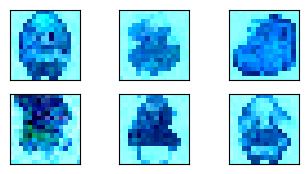

In [23]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      #human
    [1,0,0.6,0,0],    
    [0,0,0.6,0.4,0],  
    [1,0,0,0,1],  
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)